In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

### Step 1. 데이터 수집 및 전처리

In [3]:
from fredapi import Fred
import os

# FRED API 호출
FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred(api_key=FRED_API_KEY)
start_date = '1980-01-01'
end_date = '2024-12-31'

# 데이터 가져오기
yield_10y = fred.get_series('DGS10', start_date, end_date)
yield_2y = fred.get_series('DGS2', start_date, end_date)
recession = fred.get_series('USREC', start_date, end_date)

# 금리차 계산 및 데이터프레임 생성
spread = yield_10y - yield_2y
df = pd.DataFrame({'Spread': spread, 'Recession': recession}).dropna()
df['Recession'] = df['Recession'].astype(int)

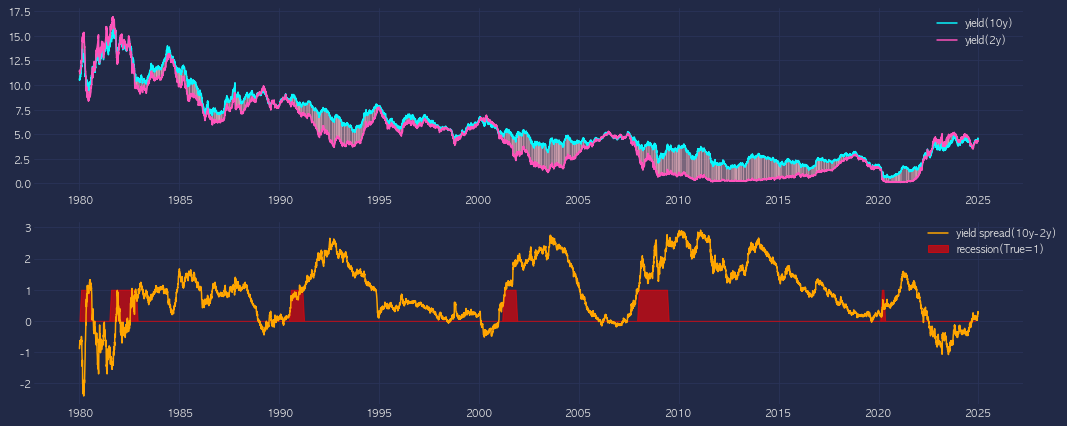

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,6))

sns.lineplot(data=yield_10y, x=yield_10y.index, y=yield_10y.values, ax=axes[0], label='yield(10y)')
sns.lineplot(data=yield_2y, x=yield_2y.index, y=yield_2y.values, ax=axes[0], label='yield(2y)')
axes[0].fill_between(x=yield_10y.index, y1=yield_2y.values, y2=yield_10y.values, color='pink', alpha=0.4)

sns.lineplot(data=spread, x=spread.index, y=spread.values, ax=axes[1], label='yield spread(10y-2y)', color='orange')
axes[1].fill_between(x=recession.index, y1=0, y2=recession.values, color='r', alpha=0.6, label='recession(True=1)')
axes[1].legend(loc=(0.9, 0.8))

plt.tight_layout()
plt.show()

- 역사적으로 장단기 금리 스프레드가 역전된 시기 직후, 경기불황 발생.

### Step 2. 금리 스프레드 시계열 패턴 분석

ADF Statistic: -3.2462
p-value: 0.0175


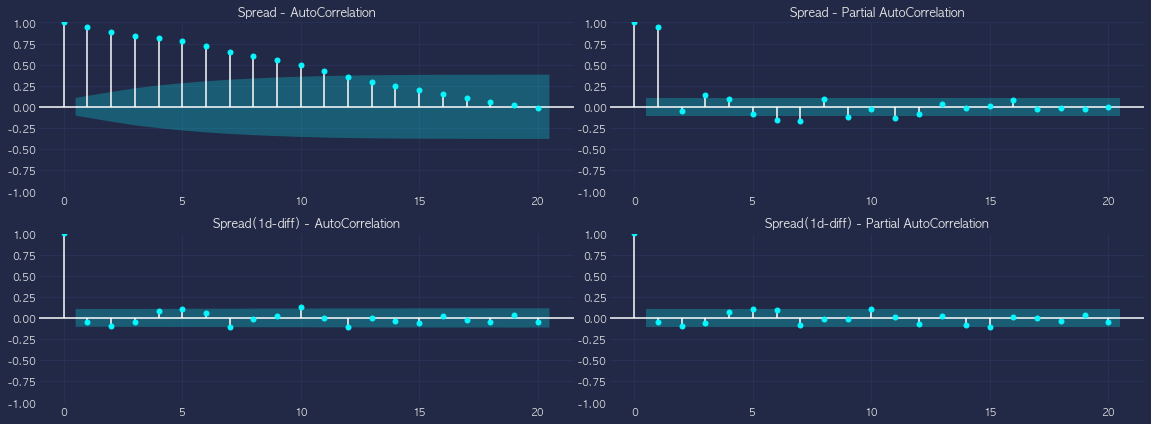

In [81]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# 정상성 검정(Adfuller Test)
adf_result = adfuller(df['Spread'], maxlag=5)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


# 시차(lag)별 자기상관성 확인
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,6))
sm.graphics.tsa.plot_acf(df['Spread'].dropna(), lags=20, ax=axes[0,0])
sm.graphics.tsa.plot_pacf(df['Spread'].dropna(), lags=20, ax=axes[0,1])

df['Spread_Diff'] = df['Spread'].diff().dropna()
sm.graphics.tsa.plot_acf(df['Spread_Diff'].dropna(), lags=20, ax=axes[1,0])
sm.graphics.tsa.plot_pacf(df['Spread_Diff'].dropna(), lags=20, ax=axes[1,1])

axes[0,0].set_title('Spread - AutoCorrelation')
axes[0,1].set_title('Spread - Partial AutoCorrelation')
axes[1,0].set_title('Spread(1d-diff) - AutoCorrelation')
axes[1,1].set_title('Spread(1d-diff) - Partial AutoCorrelation')

plt.tight_layout()
plt.show()

### Step 3. ARIMA 금리 스프레드 예측

ARIMA로 금리차 미래 값 예측, 예측값은 Probit 입력값으로 활용할 것.

In [113]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모형 적합
model_101 = ARIMA(df['Spread'], order=(1, 0, 1))  # ARIMA(p, d, q)
model_101_fit = model_101.fit()
print(f'{model_101_fit.aic:.2f}, {model_101_fit.bic:.2f}')

model_111 = ARIMA(df['Spread'], order=(1, 1, 1))  
model_111_fit = model_111.fit()
print(f'{model_111_fit.aic:.2f}, {model_111_fit.bic:.2f}')

model_010 = ARIMA(df['Spread'], order=(0, 1, 0))  
model_010_fit = model_010.fit()
print(f'{model_010_fit.aic:.2f}, {model_010_fit.bic:.2f}')

model_100 = ARIMA(df['Spread'], order=(1, 0, 0))  
model_100_fit = model_100.fit()
print(f'{model_100_fit.aic:.2f}, {model_100_fit.bic:.2f}')

140.25, 155.64
141.99, 153.52
140.20, 144.05
138.38, 149.92


138.37774623741296 149.91706256258612


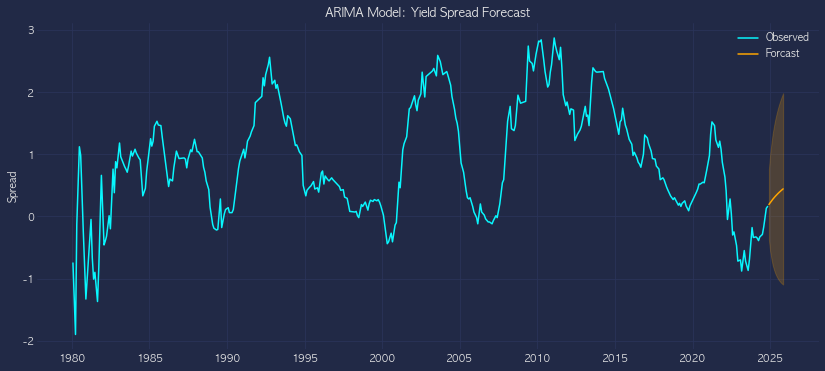

In [114]:

from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모형 적합
model = ARIMA(df['Spread'], order=(1, 0, 0))  # ARIMA(p, d, q)
model_fit = model.fit()
print(model_fit.aic, model_fit.bic)

# 미래 금리차 예측
forcast_periods = 12
forecast = model_fit.get_forecast(steps=forcast_periods)  # 12개월 예측
forecast_df = forecast.summary_frame()
forcast_idx = []
last_datetime = df.index[-1]
for i in range(1, forcast_periods+1, 1):
    forcast_idx.append(last_datetime + pd.DateOffset(months=i))
forecast_df_ts = pd.DataFrame(
                    index=forcast_idx, 
                    data={
                    'forcast': forecast_df['mean'].values})

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='Spread', label='Observed')
sns.lineplot(data=forecast_df_ts, x=forecast_df_ts.index, y='forcast', label='Forcast', color='Orange')
plt.fill_between(forecast_df_ts.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='orange', alpha=0.2)
plt.title('ARIMA Model: Yield Spread Forecast')
plt.legend()
plt.show()

In [115]:
# 독립 변수 및 상수항 추가
df['Intercept'] = 1
X = df[['Intercept', 'Spread']]  # 금리차 사용
y = df['Recession']  # 경기침체 여부

# Probit 모형 적합
probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

# 결과 출력
print(probit_results.summary())

Optimization terminated successfully.
         Current function value: 0.332714
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  346
Model:                         Probit   Df Residuals:                      344
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                0.003503
Time:                        22:38:47   Log-Likelihood:                -115.12
converged:                       True   LL-Null:                       -115.52
Covariance Type:            nonrobust   LLR p-value:                    0.3683
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1845      0.122     -9.744      0.000      -1.423      -0.946
Spread        -0.0883      0.

In [121]:
forecast_df_ts

,forcast
2024-12-01,0.190765
2025-01-01,0.219979
2025-02-01,0.247722
2025-03-01,0.274066
2025-04-01,0.299083
2025-05-01,0.322840
2025-06-01,0.345399
2025-07-01,0.366822
2025-08-01,0.387165
2025-09-01,0.406483


In [119]:
forecast_df.index = forecast_df_ts.index
forecast_df

Spread,mean,mean_se,mean_ci_lower,mean_ci_upper
346,0.190765,0.291995,-0.381535,0.763065
347,0.219979,0.402674,-0.569247,1.009205
348,0.247722,0.481122,-0.695259,1.190703
349,0.274066,0.542216,-0.788658,1.336791
350,0.299083,0.591927,-0.861071,1.459238
351,0.322840,0.633417,-0.918634,1.564314
352,0.345399,0.668627,-0.965086,1.655884
353,0.366822,0.698859,-1.002916,1.736560
354,0.387165,0.725040,-1.033888,1.808218
355,0.406483,0.747864,-1.059305,1.872270


In [130]:
df

,Spread,Recession,Spread_Diff,Intercept
1980-02-01,-0.75,1,NaN,1
1980-04-01,-1.90,1,-1.15,1
1980-05-01,-0.13,1,1.77,1
1980-07-01,1.12,1,1.25,1
1980-08-01,0.98,0,-0.14,1
...,...,...,...,...
2024-05-01,-0.33,0,0.06,1
2024-07-01,-0.29,0,0.04,1
2024-08-01,-0.17,0,0.12,1
2024-10-01,0.13,0,0.30,1


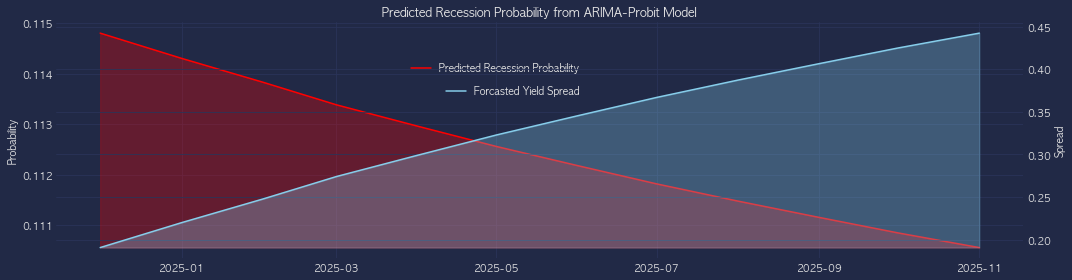

In [179]:
# Probit 모형을 사용한 예측 확률 계산
forecast_df.index = forecast_df_ts.index
forecast_df['Intercept'] = 1
forecast_df['Probit_Pred'] = probit_results.predict(forecast_df[['Intercept', 'mean']])

# 예측 확률 시각화
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
ax2 = ax1.twinx()
ax1.set_title('Predicted Recession Probability from ARIMA-Probit Model')
ax1.plot(forecast_df.index, forecast_df['Probit_Pred'], label='Predicted Recession Probability', color='red')
ax1.fill_between(x=forecast_df.index, y1=forecast_df['Probit_Pred'].min(), y2=forecast_df['Probit_Pred'], color='red',alpha=0.3)
ax2.plot(forecast_df.index, forecast_df['mean'], label='Forcasted Yield Spread', color='skyblue')
ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean'].min(), y2=forecast_df['mean'], color='skyblue',alpha=0.3)
ax1.set_ylabel('Probability')
ax2.set_ylabel('Spread')
ax2.set_xlabel('Date')

ax1.legend(bbox_to_anchor=(0.55,0.87))
ax2.legend(bbox_to_anchor=(0.55,0.77))

plt.tight_layout()
plt.show()